## Fake News Classifier Using LSTM network

Dataset: https://www.kaggle.com/c/fake-news/data#

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('data/fake_news/train.csv', index_col='id')
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df.shape

(20800, 4)

In [4]:
#drop NaN values
df.dropna(subset = ["title", "label"], inplace=True)

In [5]:
df.shape

(20242, 4)

In [6]:
#independent features
X = df.iloc[:,:-1]
X.shape

(20242, 3)

In [7]:
#independent features
y = df.iloc[:,-1]
y.shape

(20242,)

### Onehot Representation

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [9]:
#vocabulary_size
voc_size = 5000

In [10]:
X.reset_index(drop=True, inplace=True)

In [11]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [12]:
ps = PorterStemmer()

In [13]:
#data_preprocessing
corpus = []
for i in range(0, len(X)):
    if i%1000 == 0: 
        print(i) #to check how much work is done
    review = re.sub('[^a-zA-Z]', ' ', X.loc[i, 'title'])
    review = review.lower()
    review = review.split()
    #stemming
    review = [ps.stem(word) for word in review if not word in stopwords.words("english")]
    review = " ".join(review)
    corpus.append(review)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [14]:
corpus[0]

'hous dem aid even see comey letter jason chaffetz tweet'

In [15]:
onehot_repr = [one_hot(sentence, voc_size) for sentence in corpus]
onehot_repr[0]

[859, 829, 490, 2007, 3545, 4059, 4024, 2035, 1431, 2]

In [16]:
# maximum length of a title
sent_len = max([len(sent) for sent in onehot_repr])
print(sent_len)

47


### Embedding Representation

In [18]:
sent_length = sent_len
embedded_docs = pad_sequences(onehot_repr, padding="pre", maxlen=sent_length)
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  859,  829,  490, 2007, 3545, 4059, 4024,
       2035, 1431,    2])

In [19]:
len(embedded_docs), y.shape

(20242, (20242,))

In [20]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [21]:
X_final.shape, y_final.shape

((20242, 47), (20242,))

### Model Building

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

In [26]:
#hp signifies hyperparameters we are going to tune
def build_model(hp):
    #i.define model
    model = Sequential()
    #embedding layer
    model.add(Embedding(input_dim = voc_size,
                        output_dim=hp.Int("embedded_vector_features", min_value=16, max_value=512, step=16),
                        input_length=sent_length))
    #LSTM layer
    model.add(LSTM(units=hp.Int("lstm_units", min_value=16, max_value=128, step=16)))
    #dropout
    model.add(Dropout(rate=hp.Choice("dropout", [0.3, 0.4, 0.5])))
    #output Layer
    model.add(Dense(units=1, activation="sigmoid"))
    
    #ii.compile the model
    #we have to define the optimizer, loss function and evaluating metric while compiling the model
    #hp.Choice signifies the choice is from a list
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-2,1e-3,1e-4])),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [27]:
tuner = RandomSearch(build_model, objective='val_loss',
                    max_trials=10, directory="fake_news_detection",
                    project_name="fake_news_detection")

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
embedded_vector_features (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
dropout (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [29]:
tuner.search(X_train, y_train, epochs=1, validation_split=0.15)

Trial 10 Complete [00h 00m 20s]
val_loss: 0.282465398311615

Best val_loss So Far: 0.1836973875761032
Total elapsed time: 00h 03m 22s
INFO:tensorflow:Oracle triggered exit


In [30]:
model_kt = tuner.get_best_models(num_models=1)[0]

In [31]:
model_kt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 47, 32)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [32]:
#fit
model_history = model_kt.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=64)

Epoch 1/2
212/212 [==============================] - 14s 55ms/step - loss: 0.1309 - accuracy: 0.9502 - val_loss: 0.2011 - val_accuracy: 0.9135
Epoch 2/2
212/212 [==============================] - 12s 56ms/step - loss: 0.0967 - accuracy: 0.9639 - val_loss: 0.3160 - val_accuracy: 0.9195


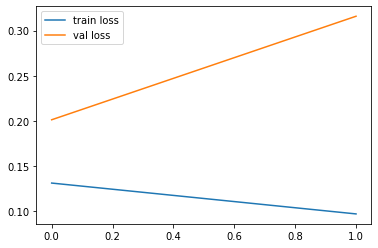

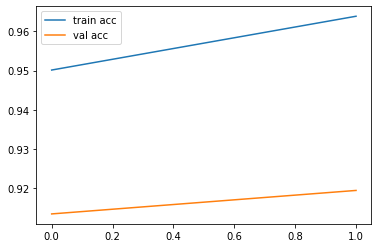

In [33]:
# plot the loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Performance Metrics and Accuracy

In [34]:
y_pred = model_kt.predict(X_test)
y_pred_binary = y_pred > 0.5
y_pred_binary

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [36]:
accuracy_score(y_test, y_pred_binary)

0.9194610778443114

In [37]:
confusion_matrix(y_test, y_pred_binary)

array([[2894,  516],
       [  22, 3248]], dtype=int64)